In [1]:
import numpy as np
import pandas as pd
import copy
import csv

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def CheckTheRunningTime(): 
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))

In [3]:
### Load the MOOC data from JODIE
mooc_df = pd.read_csv('../data/mooc.csv')
feat_list = ['feat_' + str(i) for i in range(4)]
index_list = ['user_id', 'item_id', 'timestamp']

mooc_df.columns = ['state_label'] + feat_list
mooc_df.index.names = index_list
print('Data size: ' , np.shape(mooc_df))

# Check the stats of data
print('# of users: ', len(mooc_df.index.unique(level='user_id')))
print('# of items: ', len(mooc_df.index.unique(level='item_id')))
print('# of timestamps: ', len(mooc_df.index.unique(level='timestamp')))

mooc_df.head()

Data size:  (411749, 5)
# of users:  7047
# of items:  97
# of timestamps:  345600


state_label    feat_0    feat_1    feat_2    feat_3
user_id item_id timestamp                                                     
0       0       0.0                  0 -0.319991 -0.435701  0.106784 -0.067309
        1       6.0                  0 -0.319991 -0.435701  0.106784 -0.067309
        2       41.0                 0 -0.319991 -0.435701  0.106784 -0.067309
        1       49.0                 0 -0.319991 -0.435701  0.106784 -0.067309
        2       51.0                 0 -0.319991 -0.435701  0.106784 -0.067309

In [4]:
# A positive (drop-out) example 
tmp_posId = 46
tmp_df = mooc_df.loc[pd.IndexSlice[[tmp_posId],:,:]]
tmp_df

state_label    feat_0    feat_1    feat_2    feat_3
user_id item_id timestamp                                                     
46      1       62918.0              0 -0.319991 -0.435701  1.108826  3.545219
        3       62948.0              0 -0.319991 -0.435701  0.106784 -0.067309
                63301.0              0 -0.319991 -0.435701  0.106784 -0.067309
        8       63745.0              0 -0.319991 -0.435701  0.106784 -0.067309
        3       63760.0              0 -0.319991 -0.435701  0.106784 -0.067309
        5       64474.0              0 -0.319991 -0.435701  0.106784 -0.067309
        4       64477.0              0 -0.319991 -0.435701  0.106784 -0.067309
        5       64478.0              0 -0.319991 -0.435701  0.106784 -0.067309
        4       64487.0              0 -0.319991 -0.435701  0.106784 -0.067309
                64936.0              0 -0.319991 -0.435701  0.106784 -0.067309
        15      64936.0              0 -0.319991  2.108722 -0.394237 -0.067309
        5       65572.0              1 -0.319991 -0.435701  0.106784 -0.067309

### Generate the states and actions from data

In [5]:
# CheckTheRunningTime()

In [6]:
### Convert features to discrete states 
unique_state_feat = np.array(mooc_df[feat_list].drop_duplicates())
print('# of unique states: ', len(unique_state_feat))

# Dictionary from states to features
# state_feat_dict = {i:list(unique_state_feat[i]) for i in range(len(unique_state_feat))}
state_feat_dict = {', '.join(map(str, list(unique_state_feat[i]))):i for i in range(len(unique_state_feat))}

# Descretize each feature
for feat in feat_list: 
    tmp_feat_unique = np.unique(mooc_df[feat])
    tmp_feat_dict = {tmp_feat_unique[i]:i for i in range(len(tmp_feat_unique))} 
    mooc_df[feat+'_d'] = mooc_df[feat].apply(lambda x: tmp_feat_dict[x])
    
# Get the dictionary from discrete features to indexes
feat_d_list = [feat_list[i]+'_d' for i in range(len(feat_list))]
unique_d_feat = np.array(mooc_df[feat_d_list].drop_duplicates())
state_feat_dict = {', '.join(map(str, unique_d_feat[i])):i for i in range(len(unique_d_feat))}

# Convert the features to state indexes
state_array = np.zeros([len(mooc_df)])

for tmp_feat in unique_d_feat: #[tmp_start:tmp_start+1]: 
    tmpIdx = [idx for idx, val in enumerate(np.array(mooc_df[feat_d_list])) if (val == tmp_feat).all()]
    tmpState = state_feat_dict[', '.join(map(str, tmp_feat))]
    state_array[tmpIdx] = tmpState
    
mooc_df['state_idx'] = state_array

# of unique states:  858


In [7]:
# CheckTheRunningTime()

In [8]:
### Generate the actions
mooc_sa_df = copy.deepcopy(mooc_df)
mooc_sa_df.reset_index(inplace=True) 

# Check the adjacent difference of states and items
mooc_sa_df['state_diff'] = mooc_sa_df.groupby('user_id')['state_idx'].diff().fillna(0).tolist()
mooc_sa_df['item_diff'] = mooc_sa_df.groupby('user_id')['item_id'].diff().fillna(0).tolist()

# Convert the difference to boolean
state_diff_flag = [diff != 0 for diff in mooc_sa_df['state_diff'].tolist()]
item_diff_flag = [diff != 0 for diff in mooc_sa_df['item_diff'].tolist()]

# Generate the actions
# 0: Both state and item keep the same
# 1: Item keeps the same while state changes
# 2: State keeps the same while item changes
# 3: Both state and item changes
action_list = [item_diff_flag[i]*2 + state_diff_flag[i]*1 for i in range(len(state_diff_flag))]
mooc_sa_df['action'] = action_list

# Check the unique numbers for actions
print('Unique # of actions: ', np.unique(action_list, return_counts=True))

# Get the state-action pairs
mooc_sa_df.state_idx = mooc_sa_df.state_idx.astype(int)
mooc_sa_df.action = mooc_sa_df.action.astype(int)
mooc_sa_df['SA'] = mooc_sa_df.groupby('user_id').apply(
    lambda x: pd.Series([tuple(i) for i in x[['state_idx', 'action']].values])).tolist()

# Slice the columns
sel_col = index_list + ['state_label'] + feat_list + ['state_idx', 'action', 'SA']
mooc_sa_df = mooc_sa_df[sel_col]

Unique # of actions:  (array([0, 1, 2, 3]), array([ 60866,  21381, 132412, 197090], dtype=int64))


In [9]:
mooc_sa_df[:100]

,user_id,item_id,timestamp,state_label,feat_0,feat_1,feat_2,feat_3,state_idx,action,SA
0,0,0,0.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,0,"(0, 0)"
1,0,1,6.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,2,"(0, 2)"
2,0,2,41.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,2,"(0, 2)"
3,0,1,49.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,2,"(0, 2)"
4,0,2,51.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,2,"(0, 2)"
...,...,...,...,...,...,...,...,...,...,...,...
95,17,10,39258.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,2,"(0, 3)"
96,18,3,39273.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,2,"(9, 3)"
97,19,1,39304.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,0,"(9, 2)"
98,19,2,39313.0,0,-0.319991,-0.435701,0.106784,-0.067309,0,2,"(0, 3)"


### Split the data for training, validation, and testing

In [10]:
def GetTrajbyIdxfromDf(df, idx): 
    return np.array(df.loc[df.user_id.isin(idx)].groupby('user_id').apply(lambda x: np.array([np.nan] + [list(x['SA'])])))

In [11]:
### Reformulate the data for modeling
# Check the labels
all_labs = mooc_sa_df.groupby('user_id').apply(lambda x: x['state_label'].tolist()[-1]).tolist()
print('Perc of drop-out students: ', all_labs.count(1) / len(all_labs))
print('Perc of positive iteractions: ', mooc_sa_df['state_label'].tolist().count(1) / len(mooc_sa_df))

# Get the userIds
all_userId = mooc_df.index.unique(level='user_id')

# Split the training, validation, and testing data 
tr_prec, val_prec, te_prec = 0.8, 0.1, 0.1

# Get the indexes
tr_idx = np.arange(0, int(len(all_userId) * tr_prec))
val_idx = np.arange(int(len(all_userId) * tr_prec), int(len(all_userId) * (tr_prec + val_prec)))
te_idx = np.arange(int(len(all_userId) * (tr_prec + val_prec)), len(all_userId))

# Slice the trajectoreis
tr_traj = GetTrajbyIdxfromDf(mooc_sa_df, tr_idx)
val_traj = GetTrajbyIdxfromDf(mooc_sa_df, val_idx)
te_traj = GetTrajbyIdxfromDf(mooc_sa_df, te_idx)

# Slice the labels
tr_lab = [all_labs[idx] for idx in tr_idx]
val_lab = [all_labs[idx] for idx in val_idx]
te_lab = [all_labs[idx] for idx in te_idx]

# Check the number of splitted data
print('\nThe # of training, validation, and testing data: ', len(tr_idx), len(val_idx), len(te_idx))

Perc of drop-out students:  0.5769831133815808
Perc of positive iteractions:  0.009874948087305616

The # of training, validation, and testing data:  5637 705 705


### Learn the rewards by MLIRL

In [12]:
from mdp import MDP
from MLIRL import MLIRL, DemoWeights

In [13]:
# Normalize the transitions
def NormTransitions(P, addTurb = False): 
    norm_P = copy.deepcopy(P)
    # Add a small value to each element of P with the probability of 0.1 
    for i in range(0, len(P)):
        # -------------------------------------------------------------
        # Add turbulence to the transitions
        if addTurb: 
            for j in range(0, len(P[i])):
                norm_P[i,j] = P[i,j]
                random.seed(np.prod(np.shape(P))+i*len(P)+j)
                if random.random() < 0.1:
                    norm_P[i,j] += random.random()*0.01
        # -------------------------------------------------------------
        # Normalize the transitions
        tmp_sum = np.sum(norm_P[i], axis=1)
        tmp_sum[tmp_sum == 0] = 1e-10
        norm_P[i] = norm_P[i] / tmp_sum[:, None]
    return norm_P

In [14]:
# Number of states and actions
n_actions = len(np.unique(mooc_sa_df['action']))
n_states = len(np.unique(mooc_sa_df['state_idx']))

# Estimate the transition probabilities
init_trans = np.zeros([n_states, n_actions, n_states])

# Check the start and end states
nextStates = []
for tmpId in all_userId[:1]: 
    tmpState = mooc_sa_df.loc[mooc_sa_df.user_id == tmpId].state_idx.tolist()
    tmpCurState, tmpNextState = tmpState[:-1], tmpState[1:]
    tmpAction = mooc_sa_df.loc[mooc_sa_df.user_id == tmpId].action.tolist()[:-1] 
    for idx in range(len(tmpCurState)): 
        init_trans[tmpCurState[idx], tmpAction[idx], tmpNextState[idx]] += 1
        
# Normalize the transitions
addTurb_flag = False
transitions = NormTransitions(init_trans, addTurb = addTurb_flag)

# Set the basic parameters
para = {}
para['n_states'], para['n_actions'] = n_states, n_actions
para['transitions'] = transitions
para['baseline_rewards'] = []

# States to feats mapping
para['reward_pattern'] = 'S'
para['feat_map'] = np.eye((para['n_states'])) 
para['GAMMA'] = 0.85

para['MLIRL_ITERS'] = 300
para['MLIRL_QLITERS'] = 60
para['MLIRL_w'] = 0.5
para['MLIRL_clip'] = 0.01
para['MLIRL_weight'] = 'ones'
para['verbo'] = True

In [15]:
# Learn the rewards by MLIRL
neg_idx = [idx for idx, val in enumerate(tr_lab) if val == 0] 
selDemo = np.array([tr_traj[i] for i in neg_idx])

w = DemoWeights(selDemo, para)
temp_reward, llh = MLIRL(selDemo, w, para)

iteration 10: llh = 39186.65260809335
-------------------------------------
iteration 20: llh = 39698.93029468573
-------------------------------------
iteration 30: llh = 40183.158054767904
-------------------------------------
iteration 40: llh = 40629.11253185785
-------------------------------------
iteration 50: llh = 41029.20938153812
-------------------------------------
iteration 60: llh = 41379.73365827531
-------------------------------------
iteration 70: llh = 41680.87443485971
-------------------------------------
iteration 80: llh = 41935.81787267617
-------------------------------------
iteration 90: llh = 42149.512181396916
-------------------------------------
iteration 100: llh = 42327.57716548377
-------------------------------------
iteration 110: llh = 42475.54770580731
-------------------------------------
iteration 120: llh = 42598.44953568645
-------------------------------------
iteration 130: llh = 42700.625148835235
-------------------------------------
itera

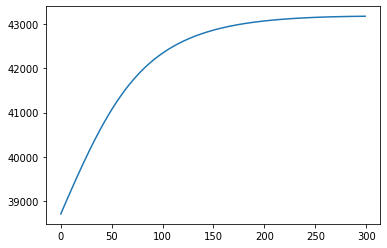

In [16]:
# Check the convergence
plt.plot(llh)

### Define the normality score

In [17]:
def RewardForGivenTrainingDemo(demo, reward): 
    state_list = [demo[1][i][0] for i in range(len(demo[1]))]
    reward_sum = np.sum([reward[i] for i in state_list])
    reward_avg = reward_sum / len(state_list)
    return reward_sum, reward_avg

In [18]:
def CalNormalityScoreForGivenDemo(demo, reward, reward_avg, reward_std): 
    state_list = [demo[1][i][0] for i in range(len(demo[1]))]
    score = sum([(reward[i] - reward_avg) / reward_std for i in state_list]) / len(demo)
    return score

In [19]:
def CheckNormalityScoreStats(traj, temp_reward, reward_avg, reward_std, verbo = True): 
    score_list = [CalNormalityScoreForGivenDemo(traj[idx], temp_reward, reward_avg, reward_std) 
                 for idx in range(len(traj))]
    if verbo: 
        print('Max Score: ', np.max(score_list))
        print('Min Score: ', np.min(score_list))
        print('Mean Score: ', np.mean(score_list))
        print('Median Score: ', np.median(score_list))
        print('\n')
    return score_list

In [20]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

def ModelEvaluate(real_lab, pre_lab, labels_list, avg_patterns='weighted', verbo=False):
    conf_matrix = confusion_matrix(real_lab, pre_lab, labels=labels_list)
    acc = accuracy_score(real_lab, pre_lab)
    recall = precision_score(real_lab, pre_lab, labels=labels_list, average=avg_patterns)
    precision = recall_score(real_lab, pre_lab, labels=labels_list, average=avg_patterns)
    fscore = f1_score(real_lab, pre_lab, labels=labels_list, average=avg_patterns)

    if verbo:
        print('Performance Measurements:')
        print('Confusion matrix: \n', conf_matrix)
        print('Accuracy: ', acc)
        print('Recall: ', recall)
        print('Precision: ', precision)
        print('F-score: ', fscore)
    return conf_matrix, [acc, recall, precision, fscore]

#### Determine the class label by normality score

In [21]:
def CheckScoreBasedPredResults(traj, real_lab, temp_reward, reward_avg, reward_std, score_thres, verbo=False): 
    # Check the normality score
    score_list = CheckNormalityScoreStats(traj, temp_reward, reward_avg, reward_std, verbo)
    
    # Get the predicted label
    # Defined by: r - mean(r) / std(r)
    pred_lab = [0 if score_list[i] > score_thres else 1 for i in range(len(score_list))]
    
    # Get the predicted scores
    prob_lab = [(i - score_thres) / (max(score_list) - score_thres) for i in score_list]
    prob_lab = [1 - (i - min(prob_lab)) / (max(prob_lab) - min(prob_lab)) for i in prob_lab]
    
    _, _ = ModelEvaluate(real_lab, pred_lab, labels_list = np.arange(2), verbo=True)
    te_fpr, te_tpr, thresholds = metrics.roc_curve(real_lab, prob_lab)
    te_roc_auc = metrics.auc(te_fpr, te_tpr)
#     print('AUC: ', te_roc_auc)

In [22]:
# Get the average rewards for all trajectories
reward_avg_list = []
for idx in range(len(selDemo)): 
    tmp_demo = selDemo[idx]
    tmp_reward_sum, tmp_reward_avg = RewardForGivenTrainingDemo(tmp_demo, temp_reward)
    reward_avg_list.append(tmp_reward_avg) 
reward_avg, reward_std = np.mean(reward_avg_list), np.std(reward_avg_list)

print('Average reward in the demos: ', reward_avg, '(', reward_std, ')')

Average reward in the demos:  2.1833982685311395 ( 0.029180315411514078 )


In [23]:
# Search for a threshold to determine the class labels
score_thres = 10
print('* Validation: ')
CheckScoreBasedPredResults(val_traj, val_lab, temp_reward, reward_avg, reward_std, score_thres)

print('\n* Testing: ')
CheckScoreBasedPredResults(te_traj, te_lab, temp_reward, reward_avg, reward_std, score_thres)

* Validation: 
Performance Measurements:
Confusion matrix: 
 [[100 150]
 [103 352]]
Accuracy:  0.6411347517730497
Recall:  0.6272291263273776
Precision:  0.6411347517730497
F-score:  0.6313303824345401

* Testing: 
Performance Measurements:
Confusion matrix: 
 [[ 97 191]
 [ 93 324]]
Accuracy:  0.5971631205673759
Recall:  0.5806768936387654
Precision:  0.5971631205673759
F-score:  0.5770473188096538


#### Determine the class label by log-likelihood

In [24]:
def NormalizeAList(score, stats = False): 
    norm_score = [1 - (i - min(score)) / (max(score) - min(score)) for i in score] 
    if stats: 
        return norm_score, max(score), min(score)
    else: 
        return norm_score

In [65]:
from EM_IRL_utils import calLogLLH_MLIRL

def CheckLLHBasedPredResults(traj, real_lab, temp_reward, thres, para): 
    # Check the normality score
    logLLH = calLogLLH_MLIRL(traj, temp_reward, para)
    norm_logLLH = NormalizeAList(logLLH)
    pred_lab = [0 if norm_logLLH[i] > thres else 1 for i in range(len(norm_logLLH))]
    
    # Get the predicted scores
    prob_lab = NormalizeAList([(thres - i) / thres for i in norm_logLLH])
    
    _, _ = ModelEvaluate(real_lab, pred_lab, labels_list = np.arange(2), verbo=True)
    te_fpr, te_tpr, thresholds = metrics.roc_curve(real_lab, pred_lab) # prob_lab)
    te_roc_auc = metrics.auc(te_fpr, te_tpr)
    print('AUC: ', te_roc_auc)

In [73]:
llh_thres = 0.2
print('* Validation: ')
CheckLLHBasedPredResults(val_traj, val_lab, temp_reward, llh_thres, para)

print('\n* Testing: ')
CheckLLHBasedPredResults(te_traj, te_lab, temp_reward, llh_thres, para)

* Validation: 
Performance Measurements:
Confusion matrix: 
 [[145 105]
 [ 53 402]]
Accuracy:  0.775886524822695
Recall:  0.77141849482275
Precision:  0.775886524822695
F-score:  0.7689370601604645
AUC:  0.7317582417582418

* Testing: 
Performance Measurements:
Confusion matrix: 
 [[ 97 191]
 [ 35 382]]
Accuracy:  0.6794326241134752
Recall:  0.6945196647324307
Precision:  0.6794326241134752
F-score:  0.6451555064321022
AUC:  0.6264363509192645


### Use LSTM for state prediction

In [57]:
from sklearn import metrics
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import RNN, LSTM, GRU, Dense, Dropout, TimeDistributed, Masking

In [58]:
mooc_df.reset_index(inplace=True)

# Reshape data as array of trajectories
trte_id = np.unique(mooc_df.user_id).tolist()
trte_data, trte_lab = [], all_labs
sel_feat = ['item_id'] + feat_list 
for vid in trte_id:
    trte_data.append(np.array(mooc_df.loc[mooc_df.user_id == vid][feat_list]))    
data_array, lab_array = np.array(trte_data), np.array(trte_lab)
    
# Truncate the trajectories to the max length
_, traj_len = np.unique(mooc_df.user_id, return_counts=True)
max_traj_len = int(np.mean(traj_len))
trunc_data_array = np.array([data_array[i][:max_traj_len] for i in range(len(trte_data))])

train_data, val_data, test_data = trunc_data_array[tr_idx], trunc_data_array[val_idx], trunc_data_array[te_idx]
train_y, val_y, test_y = lab_array[tr_idx], lab_array[val_idx], lab_array[te_idx]

In [59]:
# Pad the data to same length
X_train = sequence.pad_sequences(train_data, padding='pre')
X_test = sequence.pad_sequences(test_data, padding='pre')

if len(val_idx) > 0: 
    X_val = sequence.pad_sequences(val_data, padding='pre')

#---------------------------------------------------------------------------------------------
# Set Model parameters
data_dim = len(feat_list)
timesteps = max_traj_len
nb_class = 2
batch_size = 50 # math.gcd(math.gcd(len(X_train), len(X_test)), 100)
print('batch_size: ', batch_size)
nb_epoch = 30
class_weight = {0: 1, 1: 1}
        
# # Model structure
# RnnModel = Sequential()
# RnnModel.add(LSTM(batch_size, return_sequences=True, batch_input_shape=(batch_size, timesteps, data_dim)))
# RnnModel.add(TimeDistributed(Dense(nb_class, activation='softmax')))
# RnnModel.compile(loss='binary_crossentropy',
#              optimizer='rmsprop')
# RnnModel.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch)

batch_size:  50


In [60]:
RnnModel = Sequential()
RnnModel.add(Masking(mask_value=0., input_shape=(timesteps, data_dim)))
RnnModel.add(LSTM(50))
RnnModel.add(Dropout(0.2))
RnnModel.add(Dense(1, activation='sigmoid'))
RnnModel.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])
RnnModel.fit(X_train, train_y.tolist(), batch_size=batch_size, nb_epoch=nb_epoch)

c:\users\yangx\anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/30
5637/5637 [==============================] - 8s 1ms/step - loss: 0.6225 - acc: 0.6968
Epoch 2/30
5637/5637 [==============================] - 8s 1ms/step - loss: 0.5700 - acc: 0.7438
Epoch 3/30
5637/5637 [==============================] - 8s 1ms/step - loss: 0.5555 - acc: 0.7422
Epoch 4/30
5637/5637 [==============================] - 9s 2ms/step - loss: 0.5486 - acc: 0.7403
Epoch 5/30
5637/5637 [==============================] - 9s 2ms/step - loss: 0.5433 - acc: 0.7396
Epoch 6/30
5637/5637 [==============================] - 9s 2ms/step - loss: 0.5397 - acc: 0.7461
Epoch 7/30
5637/5637 [==============================] - 9s 2ms/step - loss: 0.5358 - acc: 0.7410
Epoch 8/30
5637/5637 [==============================] - 9s 2ms/step - loss: 0.5347 - acc: 0.7454
Epoch 9/30
5637/5637 [==============================] - 9s 2ms/step - loss: 0.5304 - acc: 0.7474
Epoch 10/30
5637/5637 [==============================] - 9s 2ms/step - loss: 0.5304 - acc: 0.7472
Epoch 11/30
5637/5637 [======

In [63]:
## Predict classes and probabilities
y_pred = RnnModel.predict_classes(X_test, batch_size=batch_size)
y_prob = RnnModel.predict(X_test, batch_size=batch_size)

In [64]:
# Evaluate the results
_, _ = ModelEvaluate(test_y, y_pred, labels_list = np.arange(2), verbo=True)

[fpr, tpr, thresholds] = metrics.roc_curve(test_y, y_prob, pos_label=1)
roc_auc = metrics.auc(fpr,tpr)
print('AUC: ', roc_auc)

Performance Measurements:
Confusion matrix: 
 [[115 173]
 [ 56 361]]
Accuracy:  0.675177304964539
Recall:  0.6745939076714017
Precision:  0.675177304964539
F-score:  0.6537595408210491
AUC:  0.6863425925925926
